# Finesse for LIGO: The `setup()` function

Author: Anna Green

_This notebook was developed as part of a series of tutorial workshops at the University of Florida in 2019. It is currently in the process of being 'polished' to fit the Learn Interferometry course._


## Goal For Today
Today we will look further at the `setup()` function and what it adds to a site model and review some tips for preparing your model to suit its purpose


## Session Outline

should cover:

1. what does setup actually do
     - skim through code, highlighting key sections and linking to what's done on site if relevant. 
     - goal is resonant arms, dark mich, res PRC, antires SRC, DARM offsetm etc - how do we get there?
2. locks and errorsigs - simple eg
     - classic e.g.: 'lock' an FP and follow another DOF changing until it breaks lock
     - caveats about Finesse lock commands vs physical locks
3. what do you need to include in your model? Efficiency vs accuracy
    - quick mini case-studies: if we want to study X, do we need Y, Z, etc

## Tasks

In [1]:
# all the usual stuff we've used before

from pykat import finesse        # import the whole pykat.finesse package
from pykat.commands import *     # import all packages in pykat.commands
import numpy as np               # for basic math/sci/array functions
import matplotlib.pyplot as plt  # for plotting
import inspect                   # for looking at source codes of functions
#ALIGO ifo pykat objects
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot as aligoplt

# tell the notebook to automatically show plots inline below each cell
%matplotlib inline               
# use pykat's plotting style. change dpi to change plot sizes on your screen
pykat.init_pykat_plotting(dpi=90)

base = aligo.make_kat()

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



### where we got to last time

#### <font color='Teal'> Task: compare the base kat object before and after running setup</font>

**1. review your work from last session & check we're all on the same page**

Make sure you're using the latest version of pykat from the LIGO git.

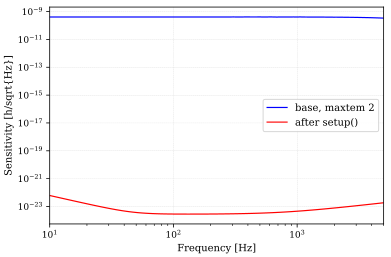

In [2]:
fig, ax = plt.subplots(1,1)
aligoplt.strain_sensitivity(base,ax=ax, plot_cmds={'label':'base, maxtem 2'})
base2 = aligo.setup(base)
aligoplt.strain_sensitivity(base2,ax=ax, plot_cmds={'label':'after setup()'})
plt.legend()

**2. print and compare base and base2 kat opjects**
what's been added and altered?

In [3]:
print(base2.getBlocks() - base.getBlocks())
set(base2.generateKatScript()) - set(base.generateKatScript())

{'errsigs', 'locks'}


{'%%% FTblock errsigs\n',
 '%%% FTblock locks\n',
 '%%% FTend errsigs\n',
 '%%% FTend locks\n',
 'func ETMX_lock = (-1.0) * $CARM_lock - 0.5 * $MICH_lock - $DARM_lock\n',
 'func ETMY_lock = (-1.0) * $CARM_lock + 0.5 * $MICH_lock + $DARM_lock\n',
 'func ITMX_lock = (-0.5) * $MICH_lock\n',
 'func ITMY_lock = 0.5 * $MICH_lock\n',
 'func PRM_lock = 1.0 * $PRCL_lock\n',
 'func SRM_lock = (-1.0) * $SRCL_lock\n',
 'lock CARM_lock $CARM_err -6e-07 0.28\n',
 'lock DARM_lock $DARM_err -0.0028 0.0061 -0.30536295999747\n',
 'lock MICH_lock $MICH_err 48.0 3.5e-05\n',
 'lock PRCL_lock $PRCL_err -3.0 0.00011\n',
 'lock SRCL_lock $SRCL_err 0.11 0.04\n',
 'm1 ETMX 5e-06 3.75e-05 -0.0043834586466165405 nETMX1 nETMXs1\n',
 'm1 ETMY 5e-06 3.75e-05 0.0043834586466165405 nETMY1 nETMYs1\n',
 'm1 ITMX 0.014 3.75e-05 -0.001 nITMXs2 nITMX2\n',
 'm1 ITMY 0.014 3.75e-05 0.001 nITMYs2 nITMY2\n',
 'm1 PRM 0.03 8.5e-06 0.001 nPRMs2 nPRM2\n',
 'm1 SRM 0.2 8.7e-06 -89.999 nSRM1 nSRMs1\n',
 'noplot ETMX_lock\n',
 'nopl

#### <font color='Purple'> Take-away: jobs of setup()</font>
1. to tune the file to an operating point
2. to generate and apply the `errsigs` and `locks` blocks

### what does setup() actually do?

#### <font color='Teal'> Task: run setup with verbose and debug modes enabled</font>
Let's see what it's actually doing

In [4]:
LIGO = base.deepcopy()
LIGO.maxtem=2
LIGO = aligo.setup(LIGO,verbose = True, debug = True)

-- pretuning interferometer to precision 0.001 deg = 2.95556e-12 m
   scanning X arm (maximising power)
   found max/min at: 0 (precision = 0.00030375)
   scanning Y arm (maximising power)
   found max/min at: 0 (precision = 0.00030375)
   scanning MICH (minimising power)
   found max/min at: -0.001 (precision = 0.00010125)
   scanning PRCL (maximising power)
   found max/min at: 0.007 (precision = 0.00030375)
   scanning SRCL (maximising carrier power, then adding 90 deg)
   found max/min at: -90.056 (precision = 0.00030375)
   ... done
-- adjusting PRC length
   adusting kat.lp1.L by -0.0002736m
-- applying user-defined DC offset:
   DCoffset = 0.003383 deg ( 1e-11m)
   at dark port power: 0.3099W
   at dark port power (TEM00 0Hz): 0.3098W
 .--------------------------------------------------.
 | pretuned for maxtem =   2, phase =  2            |
 .--------------------------------------------------.
 | port   power[W] pow. ratio | optics   tunings    |
 +----------------------------|-

#### <font color='Teal'> Task: 'inspect' setup()</font>
Let's see what it's actually doing

In [5]:
print(inspect.getsource(pykat.ifo.aligo.setup))

def setup(_base, DC_offset_pm=20, verbose=False, debug=False):
    """
    Runs a preparation routine to produce a LIGO model at a resonable operating point.
    
    Returns a copy of the base file provided with all the locks and error signals
    added.
    
    base - Base aLIGO model to tune and find an operating for
    """
    
    # Will change later when this works with the 
    old = True
    
    assert_aligo_ifo_kat(_base)
    
    base = _base.deepcopy()
    base.verbose = False

    base.removeBlock('locks',   False)
    base.removeBlock('errsigs', False)
    base.removeBlock('powers',  False)

    base.phase = 2
    susp_attr = base.IFO.fix_mirrors()

    kat = base.deepcopy()
    kat.IFO.remove_modulators()

    if old:
        pretune(kat, pretune_precision=1e-3, verbose=verbose)
    else:
        _pretune_ARM(kat, pretune_precision=1e-3, verbose=verbose)
        _pretune_MICH(kat, pretune_precision=1e-3, verbose=verbose)
        
    # Apply the tunings to our base kat

Setup is actually a wrapper function for a lot of other functions. You can of course run inspect on each of these, but essentially the first part is to get the file to an operating point, and the second part is to keep it there. 


#### Key functions:

##### finding an operating point

**pretune**
sets the kat object to an initial operating point based on the cavity resonance and dark AS port requirements.
1. make everything except the X-arm completely transparent, scan the tuning of the X-arm, record the tuning resulting in peak power and apply it to the main kat object for use going forward.
2. then repeat for Y-arm
3. then make the PRM and SRM transparent, scan MICH (move the whole X-arm and Y-arm differentially wrt BS), apply the tuning with minimum AS transmission
4. with only SRM transparent, scan PRM and apply tuning with PRC power maximised
5. with everything present, scan SRM, maximise SRC power, then add 90deg to that tuning.

**adjust_PRC_length**:
The PRC has to be resonant for the 9MHz (and by proxy the 45MHz) sidebands. This function enforces that by directly altering the macroscopic length `lp1` in the PRC, such that `lPRC = (N+1/2) * c/(2*f1)`.

**set_DC_offset**:
LIGO runs with a *nearly* dark AS port, with small offset to allow DC locking. 
If there are pre-specified tunings for the DC offset, it applies these to the ETMs then computes the resulting carrier 00 mode power. That's the case here.
Otherwise, it measures the total power (mostly sidebands) at the AS port, then sets the ETM tunings to that the total power there is twice this value.

##### Staying there
**add_errsigs_block**
removes any previous error signals block in the kat object and replaces it with one generated based on the error signals definied in the aligo IFO class object.

**generate_locks**:
1. calculates the optical gain of each major DOF (i.e. the slope of each error signal in W/rad)
2. if no accuracies are specified, generates these instead based on specified loop accuracies in meters, scaled by the optical gain and an additional 'gainsAdjustment' factor to control the relative speed of the loops 
3. records the calculated accuracies and gains for each DOF in a dictionary object for later use

**add_locks_block**
reads the dictionary generated above, and information in the IFO object, to generate the code for the lock block, then parses this to the kat object. A lot of this is still hard-coded.

### Modelling Efficiently
So now we have a base finesse model of LIGO that we know how to get to an operating point. 

Now, we need to consider *what* we want to model, and what we need to include in our model to do this accurately *and efficiently*.

#### Anything that increases the number of calcluations will slow us down 
Key types:
 - locks
 - number of field components
     - HOMs, sidebands
 - number of cavities
 - number of steps
 - number of detectors
 - number of integrations performed using surface maps, apertures, etc
 
Including everything that's included by default after setup() is inefficient, and can also potentially make the result more confusing to interpret.

However, being too over-efficient obviously means you might miss something or get a result that's just wrong. 

Usually, it's best to start with the most minimal version on your model you can cope with, then go back and re-introduce features, complexity, or higher resolution to see what difference they make, if any.

In this sense, a very handy feature is the '`kat.removeBlock()`' function.

The basic questions are:
 - do I need high maxtem?
 - do I need locks?
 - do I need the full input and output optical paths?
 - (mostly if needing high maxtem) do I need the sideband fields too?
 
Then, as you go through the model, occasionally check:
 - is the current kat object running with only the necessary detectors?
 - can I run this more quickly to test it before trying the full version

#### <font color='Teal'> Task: 'case studies' considering efficient Finesse modelling</font>
Consider the following questions posed by Mr  J.B. Commissioner. What do we need to keep in the model each time?

##### 1. "We think the beam coming in to the OMC might be astigmatic - what would that look like in an OMC scan?"
    
 * maxtem 2 minimum, since we're dealing with beam distortions; maxtem 4 so we don't limit ourselves immediately to the first order odd or even mode.
 * We don't actually need the ifo at all for this! just the OMC block and laser input.
 * The OMC on it's own doesn't need a lock, since it just passively sits there and scans.
 * The sidebands propagate to the OMC more than the carrier, so we can keep those in to see more of the 'forest' if the comissioners are interested
 * or just with a pure carrier input laser at low power, we can scan the OMC with it's default, mode matched beam, then repeat with a manually defined astigmatic input, using AD's to confirm which modes are growing. 
    
#####  2. "The test mass surfaces aren't perfectly smooth, how does this affect the contrast defect? How does it affect our sensitivity? "
    
 * we don't need any locks or sidebands here since we're not changing anything significantly in the ifo and only care about the carrier light field that will contain the GW signal.
 * we *do* need to allow for a lot of HOMs, since the surface roughness is still quite smooth and we expect to get a small amount of scatter in a lot of different modes with high spatial frequencies.
 * We only need the core interferometer, from PRM to SRM, and maybe the OMC to see if that filters anything else out. 
 * We can start with a simple model with no HOMs and compute the contrast defect and sensitivity there. then add a single map to understand the behaviour better (e.g. what maxtem is appropriate), then add the rest in.

##### 3. "The input beam is jittering. How much of that would show up at the dark port? what frequencies are especially bad?"
    
  * they essentially want a transfer function of beam jitter to the GW signal PD. 
  * so we need the full path from pre-IMC to after the OMC. 
  * but we don't need many HOMs (just enough to get alignment signals out), or sidebands.
  * Since there aren't many HOMs, keeping the sidebands in won't slow us down that much though, so that's a judgement call. 
    
#####  4. "The beamsplitter alignment signal has always been tricky, and is getting trickier with higher power. We think it's because of thermal lensing in the arms degrading the error signal"
    
  * This time we need the sidebands to generate the error signal, but not the full input path.
  * maxtem again should be around 4
  * we also need the *locks* this time, since thermal lensing will affect the error signals for the linear degrees of freedom. 
    